In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import spiral_data
import math

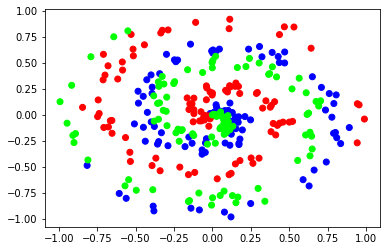

In [2]:
X,y = spiral_data(samples=100, classes=3)
X_train , y_train = X[:75] , y[:75]
X_test , y_test = X[75:] , y[75:]
plt.scatter(X[:,0] , X[:,1] , c=y,cmap='brg')

In [3]:
class Layer_Dense:  
    def __init__(self , n_in , n_out):
        self.weights = 0.01 * np.random.randn(n_in , n_out)
        self.biases = np.zeros((1,n_out))
        
    def forward(self,inputs):
        self.inputs = inputs
        self.outputs = np.dot(inputs , self.weights) + self.biases
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dinputs = np.dot(dvalues , self.weights.T)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
class ReLU:
    def forward(self,inputs):
        self.outputs =  np.maximum(0 , inputs)
        self.inputs = inputs
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <=0] = 0
        
class softmax:
    def forward(self,inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.outputs =  exp_values / np.sum(exp_values, axis=1, keepdims=True)
    def backward(self,dvalues):
        self.dinputs = np.empty_like(dvalues)
        for index , (single_output , single_dvalues) in enumerate(zip(self.output,dvalues)):
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                            single_dvalues)
class Loss:
    def calculate(self,output,targets):
        sample_loss = self.forward(output,targets)
        data_loss = np.mean(sample_loss)
        return data_loss
        
        
class CatCrossEntropyLoss(Loss):
    def forward(self,output , targets):
        if targets.ndim == 1 :
            correct_confidences = output[range(output.shape[0]) , targets]
        elif targets.ndim == 2:
            correct_confidences = np.sum(output*targets , axis=1)

        y_pred_clipped = np.clip(correct_confidences, 1e-7, 1 - 1e-7)

        neg_log = -np.log(y_pred_clipped)
        return neg_log
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        
        if y_true.ndim == 1:
            y_true = np.eye(labels)[y_true]
            
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples
        
class Activation_Softmax_Loss_CategoricalCrossentropy:
    def __init__(self):
        self.activation = softmax()
        self.loss = CatCrossEntropyLoss()
        
    def forward(self , inputs,y_true):
        self.activation.forward(inputs)
        self.outputs = self.activation.outputs
        return self.loss.calculate(self.outputs, y_true)
    
    def backward(self,dvalues, y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
            
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

def accuracy(output , targets):
    predictions = np.argmax(output , axis=1)
    if targets.ndim ==2 :
        targets = np.argmax(targets , axis = 1)
    accuracy = np.mean(predictions == targets)
    return accuracy

In [19]:
#Optimizers
class Optimizer_SGD:
    def __init__ (self, learning_rate = 1.0 , decay = 0.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.step = 0
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.step))
    
    def update_params(self, layer):
        layer.weights -= self.current_learning_rate * layer.dweights
        layer.biases -= self.current_learning_rate * layer.dbiases
        
    def post_update(self):
        self.step += 1

In [20]:
def plot(func):
    x = np.arange(-5,5,0.0001)
    y , sm_o = func(x)
    
    plt.plot([np.max(x) , np.min(x)] , [0,0] , c = 'black')
    plt.plot([0,0] , [np.max(y) , np.min(y)] , c = 'black')
    
    plt.xticks(c='white')
    plt.yticks(c='white')
    plt.xlabel('X Axis' , c = 'white')
    plt.ylabel('Y Axis' , c = 'white')
    plt.plot(x,y)

In [27]:
Layer1 = Layer_Dense(2, 64)
Layer2 = Layer_Dense(64, 3)
act1 = ReLU()
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_SGD(1 , decay= 0.001)
# Requires last layer's output and targets

lrs = []
accs = []
losses = []
for e in range(10001):
    
    Layer1.forward(X)
    act1.forward(Layer1.outputs)
    Layer2.forward(act1.outputs)
    loss = loss_activation.forward(Layer2.outputs,y)
    softmax_outputs = loss_activation.outputs
    
    acc = accuracy(loss_activation.outputs,y)
    
    if e % 1000 == 0:
        print(f'epoch: {e}, loss: {loss}, accuracy: {acc}, Lr: {optimizer.current_learning_rate}')
    
    lrs.append(optimizer.current_learning_rate)
    accs.append(acc)
    losses.append(loss)
    #Backward
    loss_activation.backward(softmax_outputs,y)
    Layer2.backward(loss_activation.dinputs)
    act1.backward(Layer2.dinputs)
    Layer1.backward(act1.dinputs)

    #Optimize
    optimizer.pre_update_params()
    optimizer.update_params(Layer1)
    optimizer.update_params(Layer2)
    optimizer.post_update()

epoch: 0, loss: 1.0985797763394802, accuracy: 0.37, Lr: 1
epoch: 1000, loss: 1.0657895220844467, accuracy: 0.4166666666666667, Lr: 0.5002501250625312
epoch: 2000, loss: 1.0374627246373493, accuracy: 0.44666666666666666, Lr: 0.33344448149383127
epoch: 3000, loss: 1.0200278462828942, accuracy: 0.44666666666666666, Lr: 0.25006251562890724
epoch: 4000, loss: 0.9967846626959954, accuracy: 0.49, Lr: 0.2000400080016003
epoch: 5000, loss: 0.9719643536308262, accuracy: 0.5033333333333333, Lr: 0.16669444907484582
epoch: 6000, loss: 0.945149703636678, accuracy: 0.5566666666666666, Lr: 0.1428775539362766
epoch: 7000, loss: 0.9143027277773332, accuracy: 0.5866666666666667, Lr: 0.12501562695336915
epoch: 8000, loss: 0.8881212591119345, accuracy: 0.6066666666666667, Lr: 0.11112345816201799
epoch: 9000, loss: 0.863344008068885, accuracy: 0.6166666666666667, Lr: 0.1000100010001
epoch: 10000, loss: 0.8423891106828058, accuracy: 0.6233333333333333, Lr: 0.09091735612328393


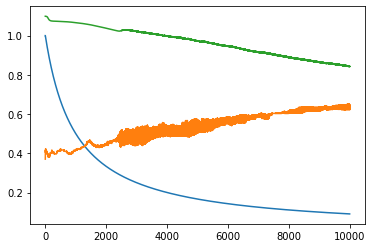

In [33]:
plt.plot(range(10001), lrs)
plt.plot(range(10001) , accs)
plt.plot(range(10001), losses)